In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle
import itertools 
import seaborn as sns
import copy

sys.path.append(os.path.join('..'))
sys.path.append(os.path.join('..', 'plots'))

import sysid as sid
importlib.reload(sid)
import helper
import config_mpl
importlib.reload(config_mpl)

import smpc_meta_building as smb


# Meta analysis system identification of a mass-spring system

In [2]:
settings = {
    'N': 12,
    'T_ini': 3,
    'train_samples': 1000,
    'test_samples': 300, 
    'state_feedback': False,
}

Settings for the investigations.

In [16]:
base_sig_x=np.array([0,0,0,0,0.5])
base_sig_y=2e-2

sig_x_fac = np.array([.1, 1, 2])
sig_y_fac = np.array([.1, 1, 2])

investigations = list(itertools.product(sig_x_fac, sig_y_fac))


In [17]:
np.random.seed(99)

train_data = []

for sig_x_fac_i, sig_y_fac_i in investigations:
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.BUILDING,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=base_sig_y*sig_y_fac_i,
        dt=1,
        case_kwargs={'state_feedback': settings['state_feedback']}
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=settings['T_ini'],
        N=settings['N'],
        n_samples=settings['train_samples'],
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(
        n_u=5, 
        u_lb = np.array([-6,-6,-6,-6, 0]).reshape(-1,1),
        u_ub = np.array([6,6,6,6,30]).reshape(-1,1),
        switch_prob=np.array([0.5, 0.5, 0.5, 0.5, 0.04]).reshape(-1,1)
        )
    
    # Generate data
    train_data.append(sid.DataGenerator(sys_generator, data_gen_setup, random_input))


test_data = []
test_data_true_cov = []

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(settings['N'])
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Initial state (identical for all test cases) 
x0_test =np.array([20, 20.5, 19.5, 21, 10]).reshape(-1,1) 


    
for sig_x_fac_i, sig_y_fac_i in investigations:

    # For all samples use a system with the same initial sequence of process and meas. noise
    test_sys_ref = sid.SystemGenerator(
            sys_type=sys_generator.sys_type,
            sig_x=base_sig_x*sig_x_fac_i,
            sig_y=base_sig_y*sig_y_fac_i,
            dt=sys_generator.dt,
            P0 = np.zeros((5,5)),
            case_kwargs={
                'state_feedback': settings['state_feedback'],
                'x0': x0_test
            },
    )()
    test_sys_ref.simulate(sequence_input, settings['T_ini'])

    def test_sys_generator():
        return copy.deepcopy(test_sys_ref)
    
    # Test data
    test_data_setup = sid.DataGeneratorSetup(
        T_ini=data_gen_setup.T_ini,
        N=data_gen_setup.N-data_gen_setup.T_ini,
        n_samples=settings['test_samples'],
    )

    # Generate test data
    test_data.append(sid.DataGenerator(test_sys_generator, test_data_setup, sequence_input))

Text(0.5, 0.98, 'Test data ')

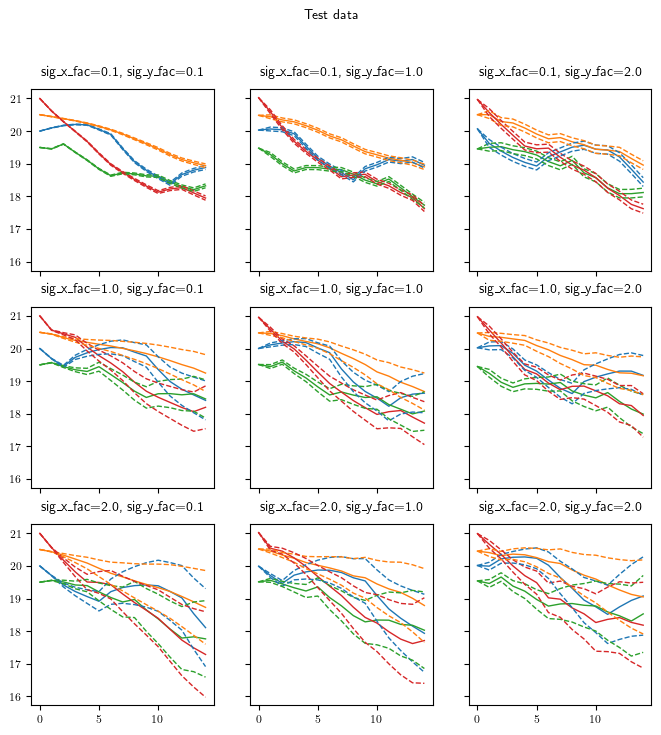

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)

for i, test_data_i in enumerate(test_data):
    k,j = np.unravel_index(i, (3,3))
    std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2))
    
    ax[k,j].plot(test_data_i.sim_results[0].y)
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].y+3*std, linestyle='--')
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].y-3*std, linestyle='--')
    ax[k,j].set_title(f'sig_x_fac={investigations[i][0]}, sig_y_fac={investigations[i][1]}', fontsize=10)

fig.suptitle('Test data ')


In [19]:
%%capture

results = []


for i, (train_data_i, test_data_i) in enumerate(zip(train_data, test_data)):
    if i==0:
        msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
        ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
    msm.fit(train_data_i)
    ssm.fit(train_data_i)

    y_msm_pred, y_msm_pred_std = msm.predict(test_data_i.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,test_data_i.n_y)
    y_msm_pred_std = y_msm_pred_std.reshape(-1,test_data_i.n_y)
    y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_data_i.M[:,[0]], with_noise_variance=True)

    msm_cov_final = msm.predict(test_data_i.M[:,[0]].T, uncert_type="cov", with_noise_variance=True)[1][-test_data_i.n_y:, -test_data_i.n_y:]

    results.append(
        {
            'y_msm_pred': y_msm_pred,
            'y_msm_pred_std': y_msm_pred_std,
            'y_ssm_pred': y_ssm_pred,
            'y_ssm_pred_std': y_ssm_pred_std,
            'msm_cov_final': msm_cov_final,
        }
    )

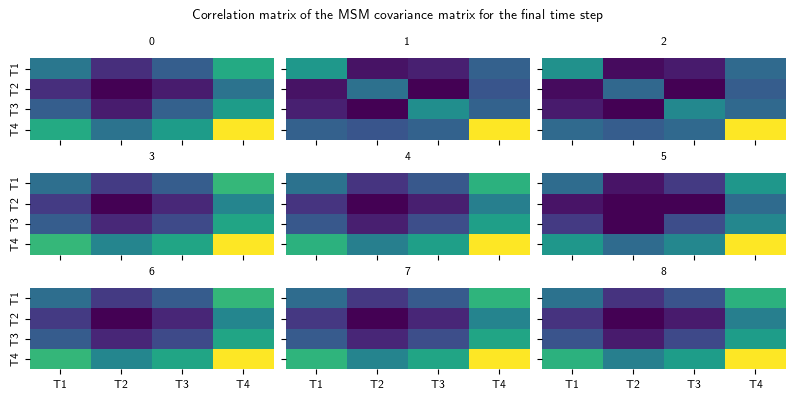

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(8, 4), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))

    names = ['T1', 'T2', 'T3', 'T4']

    if settings['state_feedback']:
        cov = results_i['msm_cov_final'][:-1,:-1]
    else:
        cov = results_i['msm_cov_final']

    corr = pd.DataFrame(cov, index=names, columns=names)

    sns.heatmap(corr, ax=ax[k,j], cmap='viridis', cbar=False)
    ax[k,j].set_title(f'{i}')

fig.suptitle('Correlation matrix of the MSM covariance matrix for the final time step')
fig.tight_layout()

Text(0, 0.5, 'T2')

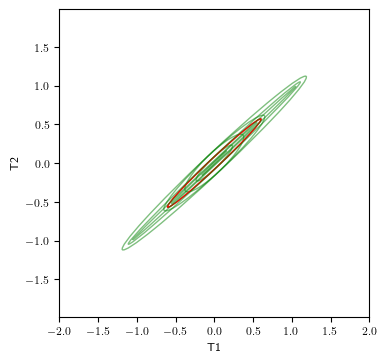

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

ax.axis('equal')

for k in range(len(investigations)):
    cov = results[k]['msm_cov_final']
    helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='g', linewidth=1, alpha=.5)
    if k == 4:
        cov = results[k]['msm_cov_final']
        helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='r', linewidth=1, alpha=1)


ax.set_xlim(-2, 2)
ax.set_ylim(-2,2)

ax.set_xlabel('T1')
ax.set_ylabel('T2')

In [22]:
def get_plot(result, test_data):
    fig, ax = plt.subplots(test_data.n_y,1, sharex=True, figsize=(10,5))

    t_ini = test_data.setup.T_ini

    y_msm_pred = result['y_msm_pred']
    y_msm_pred_std = result['y_msm_pred_std']
    y_ssm_pred = result['y_ssm_pred']
    y_ssm_pred_std = result['y_ssm_pred_std']

    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data.sim_results],axis=2)

    t = test_data.sim_results[0].time[settings['T_ini']:]
    for i in range(test_data.n_y):
        ax[i].plot(t, Y_pred[:,i,:], color='k',linewidth=1, alpha=0.05)

        ax[i].plot(t, y_ssm_pred[:,i],linewidth=2, label="SSM")
        ax[i].fill_between(t, y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

        ax[i].plot(t, y_msm_pred[:,i], '--', linewidth=2, label="MSM")
        ax[i].fill_between(t, y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

    ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

    ax[0].legend()

    return fig, ax

Text(0.5, 0.98, '$\\sigma_x$=1.0, $\\sigma_y$=1.0')

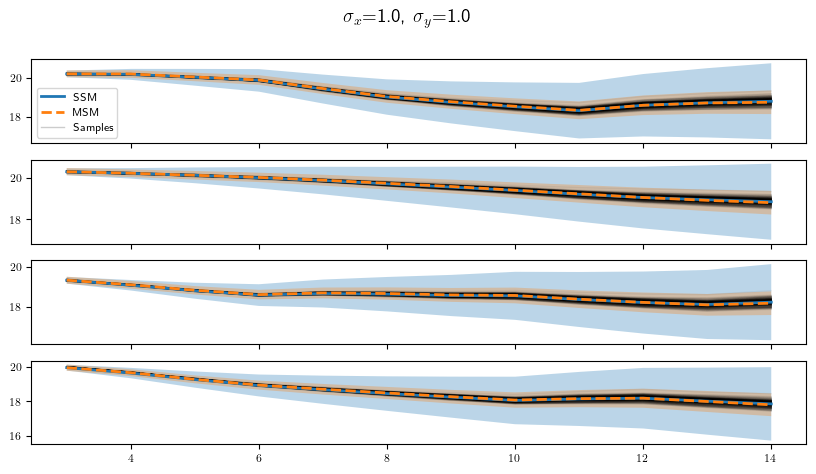

In [24]:
plot_case = 4

fig, ax = get_plot(results[plot_case], test_data[plot_case])
fig.suptitle(f'$\sigma_x$={investigations[plot_case][0]}, $\sigma_y$={investigations[plot_case][1]}', fontsize=14)

In [25]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_ratio_to_true_std(y_pred_std, true_std):
    ratio = y_pred_std/true_std
    return ratio

def get_stats(Y_true, y_pred, y_pred_std, true_std):
    norm_dist = get_normalized_distance(Y_true, y_pred, y_pred_std)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)*100
    mse = np.mean((Y_true-np.atleast_3d(y_pred))**2)
    ratio_to_true_std = np.mean(get_ratio_to_true_std(y_pred_std, true_std))

    return in_three_sigma, mse, ratio_to_true_std

In [26]:
results_post_proc = {
    'sigma_x': [],
    'sigma_y': [],
    'msm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'mse': [],
    },
    'ssm': {
        'perc. in 3 sigma': [],
        'ratio to true std': [],
        'mse': [],
    },
}

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    true_std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2))[data_gen_setup.T_ini:]

    stats_msm = get_stats(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'], true_std)
    stats_ssm = get_stats(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'], true_std)

    results_post_proc['msm']['perc. in 3 sigma'].append(stats_msm[0])
    results_post_proc['msm']['mse'].append(stats_msm[1])
    results_post_proc['msm']['ratio to true std'].append(stats_msm[2])
    results_post_proc['ssm']['perc. in 3 sigma'].append(stats_ssm[0])
    results_post_proc['ssm']['mse'].append(stats_ssm[1])
    results_post_proc['ssm']['ratio to true std'].append(stats_ssm[2])

    results_post_proc['sigma_x'].append(investigations[i][0])
    results_post_proc['sigma_y'].append(investigations[i][1])

# Normalize mse with smallest value
min_mse = np.min(np.concatenate([results_post_proc['msm']['mse'], results_post_proc['ssm']['mse']]))

print(min_mse)
    


8.363739921765228e-05


In [27]:
d1 = pd.DataFrame(results_post_proc['msm'])
d2 = pd.DataFrame(results_post_proc['ssm'])

df_case = pd.DataFrame({'sigma_x': results_post_proc['sigma_x'], 'sigma_y': results_post_proc['sigma_y']})


df = pd.concat([df_case, d1,d2], keys=['empty', 'MSM', 'SSM'],axis=1)

df['MSM']['mse'] /= min_mse
df['SSM']['mse'] /= min_mse


df

/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_57021/3424372426.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSM']['mse'] /= min_mse
/var/folders/rw/cwpn4qds40s2_r4x82fq8sph0000gn/T/ipykernel_57021/3424372426.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SSM']['mse'] /= min_mse


empty                      MSM                                \
  sigma_x sigma_y perc. in 3 sigma ratio to true std         mse   
0     0.1     0.1       100.000000          6.774090    1.282080   
1     0.1     1.0       100.000000          2.926882   11.170605   
2     0.1     2.0       100.000000          2.415243   22.167540   
3     1.0     0.1       100.000000          1.177465  197.793771   
4     1.0     1.0        99.993056          1.214354   94.762297   
5     1.0     2.0       100.000000          1.330634  169.638892   
6     2.0     0.1       100.000000          0.905744  325.200366   
7     2.0     1.0        99.833333          0.968688  693.094214   
8     2.0     2.0       100.000000          1.145086  362.638304   

               SSM                                
  perc. in 3 sigma ratio to true std         mse  
0            100.0         26.503791    1.000000  
1            100.0         12.705582    6.816475  
2            100.0          8.235665   36.014569  
3            100.0          3.867233  166.099175  
4            100.0          2.899428   89.974232  
5            100.0          2.901078   96.921659  
6            100.0          2.158927  344.164726  
7            100.0          1.742227  653.718062  
8            100.0          1.759685  310.277142

In [ ]:
tex_str = df.to_latex(
    float_format='{:0.1f}'.format,
    multicolumn=True,
    multirow=True,
    index=False,
)

tex_str = tex_str.replace('perc. in 3 sigma', r'in $\pm3\sigma$')
tex_str = tex_str.replace('ratio to true std', r'$\hat\sigma/\sigma$')
tex_str = tex_str.replace('sigma\\_x', r'$\alpha_{\sigma_a}$')
tex_str = tex_str.replace('sigma\\_y', r'$\alpha_{\sigma_r}$')
tex_str = tex_str.replace('mse', r'MSE$^*$')
tex_str = tex_str.replace('empty', r'&')


tex_str_list = tex_str.split('\n')

tex_str_list.insert(3, r'\cmidrule(lr){3-5} \cmidrule(lr){6-8}')

tex_str_list.pop(1) # Remove toprule

tex_str =  '\n'.join(tex_str_list)

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'tables')
savename = 'sid_results_matrix.tex'

with open(os.path.join(savepath, savename), 'w') as f:
    f.write(tex_str)


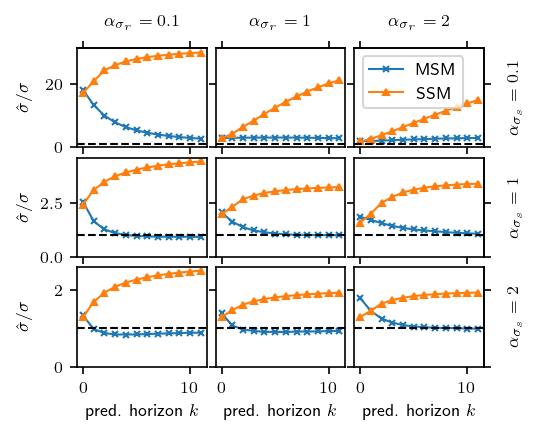

In [30]:

fig, ax = plt.subplots(3, 3, figsize=(config_mpl.columnwidth, .8*config_mpl.columnwidth), sharex=True, sharey='row', dpi=150)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)

    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P_y, axis1=1, axis2=2)))[data_gen_setup.T_ini:]
    mean_ratio_true_std_msm = np.mean(get_ratio_to_true_std(results_i['y_msm_pred_std'], true_std), axis=1)
    mean_ratio_true_std_ssm = np.mean(get_ratio_to_true_std(results_i['y_ssm_pred_std'], true_std), axis=1)

    
    ax[k,j].plot(mean_ratio_true_std_msm, '-x', label='MSM', markersize=3)
    ax[k,j].plot(mean_ratio_true_std_ssm, '-^', label='SSM', markersize=3)    
    ax[k,j].axhline(1, color='k', linestyle='--')

    ax[k,j].set_ylim(0, None)



ax[0,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[1,0].set_ylabel(r'$\hat\sigma / \sigma$')
ax[2,0].set_ylabel(r'$\hat\sigma / \sigma$')

ax[2,0].set_xlabel(r'pred. horizon $k$')
ax[2,1].set_xlabel(r'pred. horizon $k$')
ax[2,2].set_xlabel(r'pred. horizon $k$')

sec_x_axis = []
sec_y_axis = []
for i in range(3):
    sec_x_axis.append(ax[0,i].secondary_xaxis('top'))
    sec_y_axis.append(ax[i,-1].secondary_yaxis('right'))

    sec_x_axis[i].xaxis.set_ticklabels([])
    sec_y_axis[i].yaxis.set_ticklabels([])

sec_y_axis[0].set_ylabel(r'$\alpha_{\sigma_s} = 0.1$')
sec_y_axis[1].set_ylabel(r'$\alpha_{\sigma_s} = 1$')
sec_y_axis[2].set_ylabel(r'$\alpha_{\sigma_s} = 2$')

sec_x_axis[0].set_xlabel(r'$\alpha_{\sigma_r} = 0.1$')
sec_x_axis[1].set_xlabel(r'$\alpha_{\sigma_r} = 1$')
sec_x_axis[2].set_xlabel(r'$\alpha_{\sigma_r} = 2$')



ax[0,2].legend()


fig.tight_layout(pad = 0.1)
fig.align_labels()

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'figures')
savename = 'ratio_ident_vs_true_std'
fig.savefig(os.path.join(savepath, savename + '.pgf'), bbox_inches='tight', format='pgf')

## Export model

In [ ]:
%%capture

export_id = 4

train_data_i = train_data[export_id]
msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(train_data_i)
ssm.fit(train_data_i)

sig_x_fac_i, sig_y_fac_i = investigations[export_id]
sigma_x=base_sig_x*sig_x_fac_i
sigma_y=base_sig_y*sig_y_fac_i


In [ ]:
result_dir = os.path.join('sid_results')
save_name = "building_prediction_models.pkl"
save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm, 'sigma_x': sigma_x, 'sigma_y': sigma_y}
    pickle.dump(res, f)

Check if loading works

In [ ]:
with open(save_name, "rb") as f:
    res = pickle.load(f)